Классификатор для кошек/собак

In [152]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, preprocessing, regularizers
import matplotlib.pyplot as plt
import numpy as np

In [153]:
# Загружаем датасет котов и собак
dataset_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
data_dir = tf.keras.utils.get_file('cats_and_dogs.zip', origin=dataset_url, extract=True)

In [154]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator
# Делаем предобработку
import os, shutil

# предобрпботка исходных данных датасета
data_dir = os.path.join(os.path.dirname(data_dir), 'cats_and_dogs_filtered')

# Размер картинки и размер батча
img_size = (224, 224)
batch_size = 100

# Создаем датасеты
train_dataset = preprocessing.image_dataset_from_directory(os.path.join(data_dir, 'train'),
                                                           image_size=img_size,
                                                           batch_size=batch_size
                                                           )

validation_dataset = preprocessing.image_dataset_from_directory(os.path.join(data_dir, 'validation'),
                                                                image_size=img_size,
                                                                batch_size=batch_size
                                                                )

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [155]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                     include_top=False,
                                                     weights='imagenet')


In [156]:
pretrained_model.trainable = False

In [157]:
model = models.Sequential([
    layers.Rescaling(1 / 255.0, offset=-1),
    pretrained_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    layers.Dropout(0.1),
    layers.Dense(1, activation='sigmoid')
])

In [158]:
# компилируем модель
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)


In [159]:

def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    if epoch <= 10:
        return 0.0001
    return 0.00001


lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True,
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stopping, lr_callback],
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.8534 - loss: 0.4291 - val_accuracy: 0.9730 - val_loss: 0.2482 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9915 - loss: 0.1840 - val_accuracy: 0.9660 - val_loss: 0.2680 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9952 - loss: 0.1779 - val_accuracy: 0.9800 - val_loss: 0.2130 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9994 - loss: 0.1617 - val_accuracy: 0.9830 - val_loss: 0.2006 - learning_rate: 1.0000e-04
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9970 - loss: 0.1640 - val_accuracy: 0.9850 - val_loss: 0.1956 - learning_rate: 1.0000e-04
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9972 - loss: 0.1686 - val_accuracy: 0.9840 - val_loss: 0.1946 - learning_rate: 1.0000e-04
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9972 - loss: 0.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


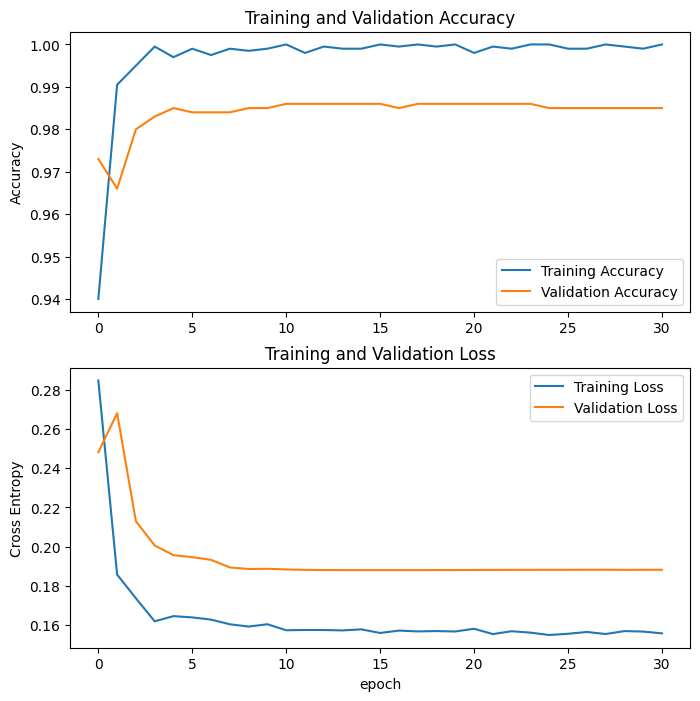

In [171]:
print(history.history.keys())
# проверяем модель и строим графики
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Тестируем работу на изображениях

In [161]:
def load_image(path: str):
    image = tf.keras.utils.load_img(path, target_size=(224, 224))
    input_arr = tf.keras.utils.img_to_array(image)
    return np.array(input_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


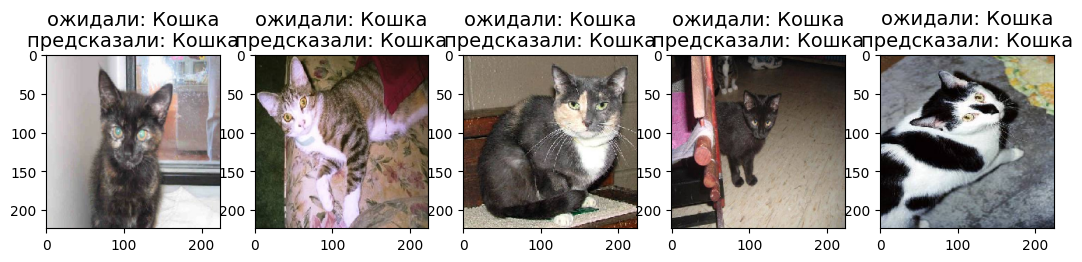

In [176]:
cat_images = np.array(list(map(lambda p: load_image(os.path.join(data_dir, 'validation/cats', p)),
                               os.listdir(os.path.join(data_dir, 'validation/cats'))))[:5])
predicted_cats = model.predict(cat_images)
plt.figure(figsize=(13, 8))
for index, (image, predicted) in enumerate(list(zip(cat_images, predicted_cats))):
    predicted = 'Собака' if tf.round(predicted) == 1 else 'Кошка'
    plt.subplot(1, 5, index + 1)
    plt.imshow(image.astype(np.uint))
    plt.title(f'ожидали: Кошка\nпредсказали: {predicted}', fontsize=14)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


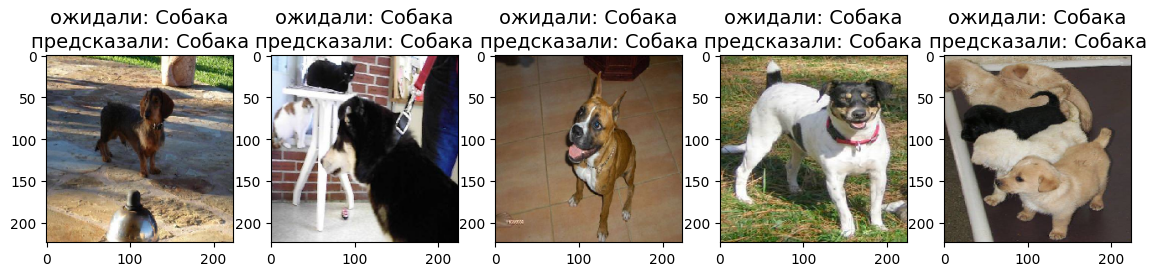

In [175]:
dog_images = np.array(list(map(lambda p: load_image(os.path.join(data_dir, 'validation/dogs', p)),
                               os.listdir(os.path.join(data_dir, 'validation/dogs'))))[:5])
predicted_dogs = model.predict(dog_images)
plt.figure(figsize=(13, 8))
for index, (image, predicted) in enumerate(list(zip(dog_images, predicted_dogs))):
    predicted = 'Собака' if tf.round(predicted) == 1 else 'Кошка'
    plt.subplot(1, 5, index + 1)
    plt.imshow(image.astype(np.uint))
    plt.title(f'ожидали: Собака\nпредсказали: {predicted}', fontsize=14)
plt.show()